# A detailed tour through Gluon

## imports

In [10]:
import math
from mxnet import nd, gluon, autograd

import mxnet as mx
import seaborn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import random

In [3]:
ctx = mx.gpu()
batch_size=10
sample_size = 10000

# Creating Synthetic Data

In [4]:
X = nd.random_normal(loc=0, scale=1, shape=(sample_size,2))
def fn(X, noise=.001):
    noise_term = noise * nd.random_normal(loc=0, scale=1, shape=(sample_size,))
    return (2 * X[:, 0] + 3.1 * X[:, 1] + math.pi) + noise
y = fn(X)
print(X.shape, y.shape)

(10000, 2) (10000,)


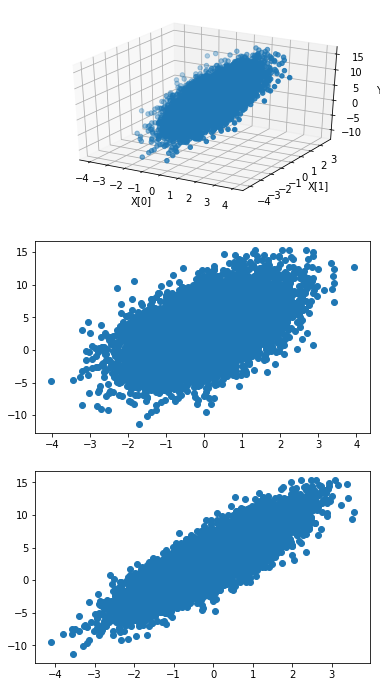

In [22]:
fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311, projection='3d')
ax.scatter(X[:,0].asnumpy(),X[:,1].asnumpy(),y.asnumpy())
ax.set_xlabel('X[0]')
ax.set_ylabel('X[1]')
ax.set_zlabel('Y')
plt.subplot(3, 1, 2)
plt.scatter(X[:,0].asnumpy(), y.asnumpy())
plt.subplot(3, 1, 3)
plt.scatter(X[:,1].asnumpy(), y.asnumpy())
plt.show()

In [23]:
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X,y), shuffle=True, batch_size=batch_size, last_batch='keep')

# Define a Network

In [24]:
def define_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    return net

In [25]:
net = define_net()
net.collect_params()



sequential0_ (
  Parameter sequential0_dense0_weight (shape=(1, 0), dtype=float32)
  Parameter sequential0_dense0_bias (shape=(1,), dtype=float32)
)

# Initialize Parameters

In [26]:
net.collect_params().initialize(mx.init.Normal(), ctx=ctx, force_reinit=True)

## More initialization algorithms and parameters
for further information check the [API documentation](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html)

|Function|Description|notes|
|:---|:---|:---|
|Uniform|Initializes weights with random values uniformly sampled from a given range.|![dd](http://mathworld.wolfram.com/images/eps-gif/UniformDistribution_651.gif)A uniform distribution has constant probability|
|Normal|Initializes weights with random values sampled from a normal distribution with a mean of zero and standard deviation of sigma.|![](http://mathworld.wolfram.com/images/eps-gif/NormalDistribution_651.gif)A normal distribution in a variate X with mean mu and variance sigma^2 is a statistic distribution with probability density function P(x)|
|Load|Initializes variables by loading data from file or dict.||
|Mixed|Initialize parameters using multiple initializers.||
|Zero|Initializes weights to zero.||
|One|Initializes weights to one.||
|Constant|Initializes the weights to a given value.||
|Orthogonal|Initialize weight as orthogonal matrix.|A Matrix A is orthagonal if $AA^T=I\ or\ A^{-1}=A^T$. Intentions is to use initialize conditions to benefit from depth independent finite delay in learning|
|Xavier|Returns an initializer performing “Xavier” initialization for weights.|This initializer is designed to keep the scale of gradients roughly the same in all layers. Randomizarion can be Uniform or Average|
|MSRAPrelu|Initialize the weight according to a MSRA paper.|[paper](https://arxiv.org/pdf/1502.01852.pdf)|
|Bilinear|Initialize weight for upsampling layers.|
|FusedRNN|Initialize parameters for fused rnn layers.|![](../images/FusedRNN.png)[1]|
|LSTMBias|Initialize all biases of an LSTMCell to 0.0 except for the forget gate whose bias is set to custom value.||

In [28]:
some_data = nd.array([[1,2]], ctx=ctx)
print(some_data.shape, net(some_data))

(1, 2) 
[[-0.0115745]]
<NDArray 1x1 @gpu(0)>


In [29]:
net.collect_params()

sequential0_ (
  Parameter sequential0_dense0_weight (shape=(1, 2), dtype=float32)
  Parameter sequential0_dense0_bias (shape=(1,), dtype=float32)
)

# Defining loss function

In [30]:
loss_fn = gluon.loss.L2Loss()

## Further loss functions

|Function|Description|Notes|
|:-|:-|:-
|[L2Loss](https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.L2Loss)|Calculates the mean squared error between pred and label.||
|[L1Loss](https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.L1Loss)|Calculates the mean absolute error between pred and label.||
|[SigmoidBinaryCrossEntropyLoss](https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SigmoidBinaryCrossEntropyLoss)|The cross-entropy loss for binary classification.||
|[SoftmaxCrossEntropyLoss](https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss)|Computes the softmax cross entropy loss.||
|KLDivLoss|The Kullback-Leibler divergence loss.|KLDiv is a measure of divergence between two distributions. $\mathcal{L}=\sum^N_{i=1}{y_i}.log\ \frac{y_i}{\hat{y_i}}$ <br> in if `from_logits` is set to `True`, then instead of $\hat{y_i}$, $softmax(\hat{y_i})$ is used.|
|HuberLoss|Huber Loss is used in Robust Regression. Robust regression performs better in presense of outliers or the model us suspeced to be heteroscedastic, when sub populations have different variabilities.|Calculates smoothed L1 loss that is equal to L1 loss if absolute error exceeds rho but is equal to L2 loss otherwise.  $$\mathcal{L} = \sum_i
    \begin{cases} 
      \frac{1}{2\rho}(\hat{y_i}-y_i)^2 & if\ |\hat{y_i}-y_i| < \rho \\
       |\hat{y_i}-y_i| - \frac{\rho}{2}& otherwise 
    \end{cases}$$|
|HingeLoss|Calculates the hinge loss function often used in SVMs||
|SquaredHingeLoss|Calculates the soft-margin loss function used in SVMs||
|LogisticLoss|Calculates the logistic loss (for binary losses only)||
|TripletLoss|Calculates triplet loss given three input tensors and a positive margin.|[paper](https://arxiv.org/pdf/1503.03832.pdf)|
|CTCLoss|Connectionist Temporal Classification Loss.|[paper](https://www.cs.toronto.edu/~graves/icml_2006.pdf)|




# Optimization
Gluon Trainer applies and optimizer and set parameters for that optimizer.

In [31]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': .9})

ref: [2][3][4][5]

# Further optimization algorithms
Gradient Descent's goal is to minimize the objective fucnction $J(\theta)$ parameterized by a model's prameters $\theta$ through updating the parameters in the opposite direction of the gradient of the objective function. learning rate $\eta$ determines the stize of the step we are taking in the direction of a local minima.



|Function|Description|notes|
|:---|:---|:---|
|SGD|Stochastic Gradient Descent with momentum and weight decay|Applies SGD to each minibatch. A good rule of thump for setting the parameters is learning rate of .001 with momentum of .9. SGD has trouble navigating areas that one one dimention is significantly more steep than others. SGD can get stuck in local minimas. adding a momentum term (fraction $\lambda$ to previous update term) we can address this problem to some extent|![](http://ruder.io/content/images/2015/12/without_momentum.gif)|
|NAG|Nesterov Accelerated Gradient|Momentum does continue down the slope with speed. Knowing where the gradient is headed helps slowing down the descent towards the local minimas. NAG looks ahead to approximate the future position of parameters and adaptively adjust the momentum. NAG first makes a big jump in the direction of the previous accumulated gradient (brown vector), measures the gradient and then makes a correction (red vector), which results in the complete NAG update (green vector). NAG can help with RNN training performance.|![](http://ruder.io/content/images/2016/09/nesterov_update_vector.png)|
|RMSProp|RMSProp Optimizer|RMSProp is similar to AdaDelta and saves the same functino of reducing agressiveness of AdaGrad decaying of learning rate.||
|adam|Adaptive Moment Estimation|Adam is another adaptive variant of SGD. Adam can be viewed as a combination of RMSprop and momentum. It works better than other adaptive methods in most cases||
|AdaGrad|Adaptive Gradinet Descent|Adaptively reducing learning rate to the parameters to perform smaller updates. This results in large updates in the beginning and progressively smaller updates, resulting in faster convergence.||
|AdaDelta|An extension of AdaGrad that reduces agressiveness of AdaGrad|Ada Delta tends to use a decaying average of all the past gradients||
|Adamax|Generalized case of adam|The vt factor in the Adam update rule scales the gradient inversely proportionally to the $\mathcal{l}_2$ norm of the past gradients and current gradient. Adamax generalizes this to $\mathcal{l}_{\infty}$||
|Nadam|Nesterov-accelerated Adaptive Moment Estimation|Nadam combines Nadam and NAG. It improves Adam by using smarter momentum term as oppsoed to vanilla momentum.||
|DCASGD [3]|Delay Compensated Asynchronous Stochastic Gradient Descent|ASGD is designed to asynchronously update the gradients, but sufferes from "delayed gradients". This is when a worker updates the global model, but the model has already been updated by another worker. DCASGD compensates this delay. This is a useful method for very large and deep models.|![](../images/CIFAR10DCASGD.png)![](../images/ImageNetDCASGD.png)|
|SGLD|Stochastic Gradient Langevin Dynamics|[paper](https://arxiv.org/abs/1702.05575)|
|Signum[4]|Compressed Optimisation for Non-Convex Problems|Cost of communicating gradients could be a major bottleneck in distributing learning actoss multiple workers. signSGD alleviates this problem by transmitting just the sign of each minibatch stochastic gradient.|![](../images/Signum.png) SGD---Signum---Adam|
|FTML[5]|Follow the Moving Leader|Inspired by onlne learning algorithms based on Follow the Regularized Leader provides improved stability over RMSProp and better performance over adam, especially in changing environments|![](../images/FTML.png)  Results on neural conversational model|
|LBSGD [6][7]|Large Batch SGD with momentum and weight decay|Large batches help increasing training speed, but come at teh cost of loss of stability. There are techniques that allow us to train models on large batches (1000 scale) while performing as well as training the same model on small batch size. The techniques hinge on the idea of adaptive batch size and include warmupss, Linear Scaling, and Batch Normalization|![](https://cdn-images-1.medium.com/max/2000/1*iUXQPXWTHbfPlKIzNq75mQ.png)|
|Ftrl|[Ftrl optimizer](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html#mxnet.optimizer.Ftrl)|[paper](http://dl.acm.org/citation.cfm?id=2488200)|


|||
|---|---|
|![](http://ruder.io/content/images/2016/09/contours_evaluation_optimizers.gif)|![](http://ruder.io/content/images/2016/09/saddle_point_evaluation_optimizers.gif)|
|SGD optimization on loss surface contours|SGD optimization on saddle point|REF:[2]|




for further information please check [MXNet documentation](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html).

# Training Loop

In [32]:
epochs = 2
for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            y_hat = net(data)
            loss = loss_fn(y_hat, label)
        autograd.backward(loss)
        trainer.step(batch_size=batch_size)
    
    print("epoch: {}".format(e))

epoch: 0
epoch: 1


# Evaluation Metrics

epoch: 0; batch: 0; RMSE: 5.75909423828125
epoch: 0; batch: 100; RMSE: 5.115272647083396
epoch: 0; batch: 200; RMSE: 4.865111692627864
epoch: 0; batch: 300; RMSE: 4.851251441378926
epoch: 0; batch: 400; RMSE: 4.8372825250364
epoch: 0; batch: 500; RMSE: 4.819611959590645
epoch: 0; batch: 600; RMSE: 4.795169176952216
epoch: 0; batch: 700; RMSE: 4.783590745653814
epoch: 0; batch: 800; RMSE: 4.762738014130705
epoch: 0; batch: 900; RMSE: 4.760877532779046
epoch: 1; batch: 0; RMSE: 3.6324820518493652
epoch: 1; batch: 100; RMSE: 4.747045592506333
epoch: 1; batch: 200; RMSE: 4.820028872039187
epoch: 1; batch: 300; RMSE: 4.760983294426801
epoch: 1; batch: 400; RMSE: 4.782469563353389
epoch: 1; batch: 500; RMSE: 4.797866639024959
epoch: 1; batch: 600; RMSE: 4.8111508039388795
epoch: 1; batch: 700; RMSE: 4.791534666328049
epoch: 1; batch: 800; RMSE: 4.785685596394628
epoch: 1; batch: 900; RMSE: 4.782271642399151


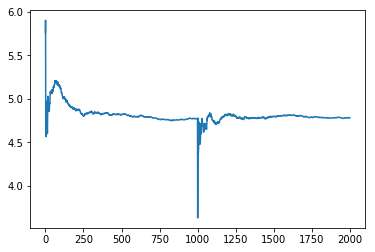

In [33]:
epochs = 2
log_interval = 100
metrics = mx.metric.RMSE()
log = []
for e in range(epochs):
    metrics.reset()
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            y_hat = net(data)
            loss = loss_fn(y_hat, label)
        autograd.backward(loss)
        trainer.step(batch_size=batch_size)
        metrics.update(labels=loss, preds=y_hat)
        log.append(metrics.get()[1])
        if not(i % log_interval):
            print("epoch: {}; batch: {}; RMSE: {}".format(e,i,metrics.get()[1]))
plt.plot(log)
plt.show()

## More supported Evaluation Metrics
|Function|Description|notes|
|:---|:---|:---|
|Accuracy|Computes accuracy classification score.|$Accuracy(y, \hat{y})=\frac{1}{n}\sum_{i=0}^{n-1}1(y_i==\hat{y_i}))$|
|TopKAccuracy|Computes top k predictions accuracy.||
|F1|Computes the F1 score of a binary classification problem.|best value is 1.0 and the worst value is 0.0. The F1 score only support binary classification problems<br>`F1 = 2 * (precision * recall) / (precision + recall)`<br>`precision = true_positives / (true_positives + false_positives)`<br>`recall = true_positives / (true_positives + false_negatives)`|
|MCC|Computed Matthews Correlation Coefficient|Supports only binary classification and is slower than F1 but provided more insight by including TN. 1 is completely correlated, 0 is uncorrelated, and -1 is negatively correlated<br><br>$MCC=\frac{TP \times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$
|Perplexity|Computes perplexity. Perplexity is a measurement of how well a probability distribution or model predicts a sample. A low perplexity indicates the model is good at predicting the sample.|$perplexity(q)=e^{-\frac{1}{N}\sum{_{i=1}^N}log(q(x_i))}$|
|MAE|Computes MAE (Mean Absolute Error) Loss|is a measure of difference between two continuous variables.. <br>$$MAE=\frac{1}{N}\sum_i^n|y_i-\hat{y_i}|$$|
|MSE|Computes Mean Squared Error Loss|The MSE is a measure of the quality of an estimator—it is always non-negative, and values closer to zero are better. MSE captures both varince and bias of an estimtor.<br>$$MSE=\frac{\sum_{i=1}^n(y_i-\hat{y_i})^2}{n}$$<br> Source: Wikipedia|
|RMSE|Computes Root Mean Squred Error (RMSE) loss.|RMSE measures accuracy of a forecae within a dataset. <br>$$RMSE=\sqrt{\frac{\sum_{i=1}^{n}(y_i-\hat{y_i})^2}{n}}$$Compared to MSE, RMSE penalized lirge errors for aggressively by squaring them.[8]![8](https://cdn-images-1.medium.com/max/1600/1*YTxb8K2XZIisC944v6rERw.png)|
|CrossEntropy|Computes cross-entropy loss.|Cross-Entropy loss is a measure of performance in classification models where output is a propability value. The closer probability of a prediction is to an associated observation, the smaller the loss will be. Cross-Entropy loss is alternatively called log loss. <br> $$\mathcal{L} = -\sum_{n=1}^{N}{\sum_{k=1}^{K}{t_{nk}log(y_{nk})}}$$ $$N:sample size; K:num classes, y_{nk}: P(y\ blowongs to class\ k); t_{nk}=1\Leftrightarrow n\ belongs\ to\ k$$|
|PearsonCorrelation|Computes Pearson correlation.|PCC measures linear correlation between two populations with values between -1 and 1. 1 is positive correlation, 0 is no correlation, and -1 expresses that the two populations are negatively correlated.<br> $$\rho_{X,Y} = \frac{cov(X,Y)}{\sigma_X\sigma_y}\ where cov(X,Y)=\mathbb{E}[(X-\mu_x)(Y-\mu_y)]$$ |
|CustomMetrics|Computes a customized evaluation metric that can be passed to the fucntion as a parameter|`fval = lambda x,y: (x + y).mean()`<br>`eval_metrics = mx.metric.CustomMetric(feval=feval)`|


## Using multiple metrics

In [34]:
epochs = 2
log_interval = 100
eval_fn = lambda x, y: ((x + y).mean())
custom_metric = mx.metric.CustomMetric(feval=eval_fn, name='Nonsensical')
child_metrics = [mx.metric.RMSE(), mx.metric.Accuracy(), mx.metric.Perplexity(ignore_label=None), custom_metric]
metrics = mx.metric.CompositeEvalMetric()
for c in child_metrics:
    metrics.add(c)

log = []
for e in range(epochs):
    metrics.reset()
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            y_hat = net(data)
            loss = loss_fn(y_hat, label)
        autograd.backward(loss)
        trainer.step(batch_size=batch_size)
        metrics.update(labels=loss, preds=y_hat)
        log.append(metrics.get())
        
        if not(i % log_interval):
            print("epoch: {}; batch: {}; RMSE: {}".format(e,i,metrics.get_name_value()))




epoch: 0; batch: 0; RMSE: [('rmse', 4.1847271919250488), ('accuracy', 1.0), ('perplexity', 5076.1694073186), ('Nonsensical', 1.9098271131515503)]
epoch: 0; batch: 100; RMSE: [('rmse', 4.7869715124073595), ('accuracy', 1.0), ('perplexity', 31.177882592919246), ('Nonsensical', 3.2035175605796939)]
epoch: 0; batch: 200; RMSE: [('rmse', 4.771524448299882), ('accuracy', 1.0), ('perplexity', 33.85045601323102), ('Nonsensical', 3.1476228099446093)]
epoch: 0; batch: 300; RMSE: [('rmse', 4.7823547730810221), ('accuracy', 1.0), ('perplexity', 35.78320299943983), ('Nonsensical', 3.1567350846910198)]
epoch: 0; batch: 400; RMSE: [('rmse', 4.798340507873573), ('accuracy', 1.0), ('perplexity', 31.375946269691724), ('Nonsensical', 3.1954133988560138)]
epoch: 0; batch: 500; RMSE: [('rmse', 4.7817593696350587), ('accuracy', 1.0), ('perplexity', 31.912948143751365), ('Nonsensical', 3.1806500346256708)]
epoch: 0; batch: 600; RMSE: [('rmse', 4.7983098597375804), ('accuracy', 1.0), ('perplexity', 30.9014675

# Plotting the results


In [35]:
from gluoncv.utils import TrainingHistory
epochs = 2
log_interval = 100
eval_fn = lambda x, y: ((x + y).mean())
custom_metric = mx.metric.CustomMetric(feval=eval_fn, name='Nonsensical')
child_metrics = [mx.metric.RMSE(), mx.metric.Accuracy(), mx.metric.Perplexity(ignore_label=None), custom_metric]
metrics = mx.metric.CompositeEvalMetric()
ths = []    

for c in child_metrics:
    metrics.add(c)
    ths.append(TrainingHistory([c.name, c.name+"_val"]))    

log = []
for e in range(epochs):
    metrics.reset()
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            y_hat = net(data)
            loss = loss_fn(y_hat, label)
        autograd.backward(loss)
        trainer.step(batch_size=batch_size)
        metrics.update(labels=loss, preds=y_hat)
        log.append(metrics.get())
        for j in range(len(metrics.get()[0])):
            val = metrics.get()[1][j]
            ths[j].update([val, val/2])          
        
        if not(i % log_interval):
            print("epoch: {}; batch: {}; RMSE: {}".format(e,i,metrics.get_name_value()))


epoch: 0; batch: 0; RMSE: [('rmse', 7.0523996353149414), ('accuracy', 1.0), ('perplexity', 31.529662189954692), ('Nonsensical', 5.4456920623779297)]
epoch: 0; batch: 100; RMSE: [('rmse', 4.824237596870649), ('accuracy', 1.0), ('perplexity', 27.0322538807582), ('Nonsensical', 3.241964614774921)]
epoch: 0; batch: 200; RMSE: [('rmse', 4.7624347779288216), ('accuracy', 1.0), ('perplexity', 27.27133433688382), ('Nonsensical', 3.2206263673394475)]
epoch: 0; batch: 300; RMSE: [('rmse', 4.7307679740297441), ('accuracy', 1.0), ('perplexity', 34.462395687105165), ('Nonsensical', 3.1538805974975377)]
epoch: 0; batch: 400; RMSE: [('rmse', 4.6974329009020419), ('accuracy', 1.0), ('perplexity', 32.76333094766842), ('Nonsensical', 3.1227623753045264)]
epoch: 0; batch: 500; RMSE: [('rmse', 4.7265331626176357), ('accuracy', 1.0), ('perplexity', 32.0589045406587), ('Nonsensical', 3.1510877606576075)]
epoch: 0; batch: 600; RMSE: [('rmse', 4.7588216223058213), ('accuracy', 1.0), ('perplexity', 30.44815985

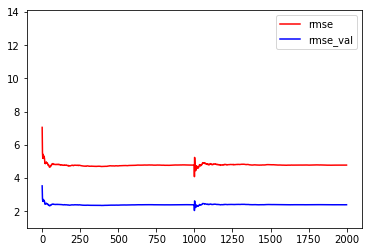

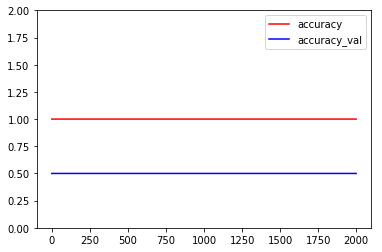

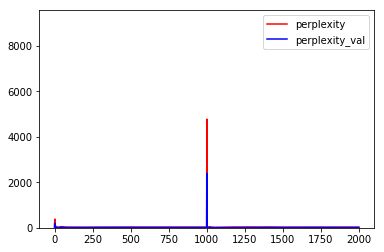

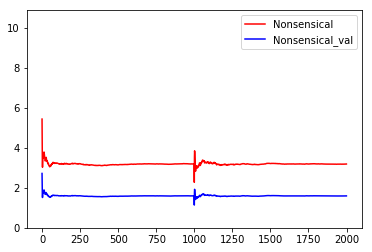

In [36]:
min_val, max_val = 0, 0
for th in ths:
    min_val =  nd.array(th.history[th.labels[0]]).min().asscalar()
    min_val = min(min_val, nd.array(th.history[th.labels[1]]).min().asscalar()) // 2
    max_val =  nd.array(th.history[th.labels[0]]).max().asscalar()
    max_val =  max(max_val, nd.array(th.history[th.labels[1]]).max().asscalar()) * 2
    th.plot(labels=th.labels, y_lim=(min_val, max_val), colors=('red', 'blue'))
    


# Refrences:
1. EcoRNN: Fused LSTM RNN Implementation with Data Layout Optimization Zheng et al.: arXiv:1805.08899
2. Sebastian Ruder: [http://ruder.io/optimizing-gradient-descent/](http://ruder.io/optimizing-gradient-descent/)
3. Asynchronous Stochastic Gradient Descent with Delay Compensation; Zheng et al.: arXiv:1609.08326 [cs.LG]
4. Compressed Optimisation for Non-Convex Problems. Anandkumar et al.: arXiv:1802.04434 [cs.LG]
5. Follow the Moving Leader in Deep Learning. Zheng et al.: [paper](http://proceedings.mlr.press/v70/zheng17a/zheng17a.pdf)
6. Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour, He et al.: arXiv:1706.02677 [cs.CV] 
7. [Twards Data Science Blog](https://towardsdatascience.com/deep-learning-at-scale-accurate-large-mini-batch-sgd-8207d54bfe02). This is an intuitive version of [6].
8. [MAE and RMSE — Which Metric is Better?](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d)